USER OVERVIEW ANALYSIS

Connecting to database

In [1]:
import pandas as pd
from sqlalchemy import create_engine

database_name = 'telecom'
table_name= 'xdr_data'

connection_params = { "host": "localhost", "user": "postgres", "password": "postgres",
                    "port": "5000", "database": database_name}

engine = create_engine(f"postgresql+psycopg2://{connection_params['user']}:{connection_params['password']}@{connection_params['host']}:{connection_params['port']}/{connection_params['database']}")

Read and explore the dataset 

In [ ]:
# str or SQLAlchemy Selectable (select or text object)
sql_query = 'SELECT * FROM xdr_data'

df = pd.read_sql(sql_query, con= engine)
# Display the first few rows of the dataset
print(df.head())

# Get information about the dataset
print(df.info())

# Summary statistics of numerical columns
print(df.describe())


      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

Identify Missing Values

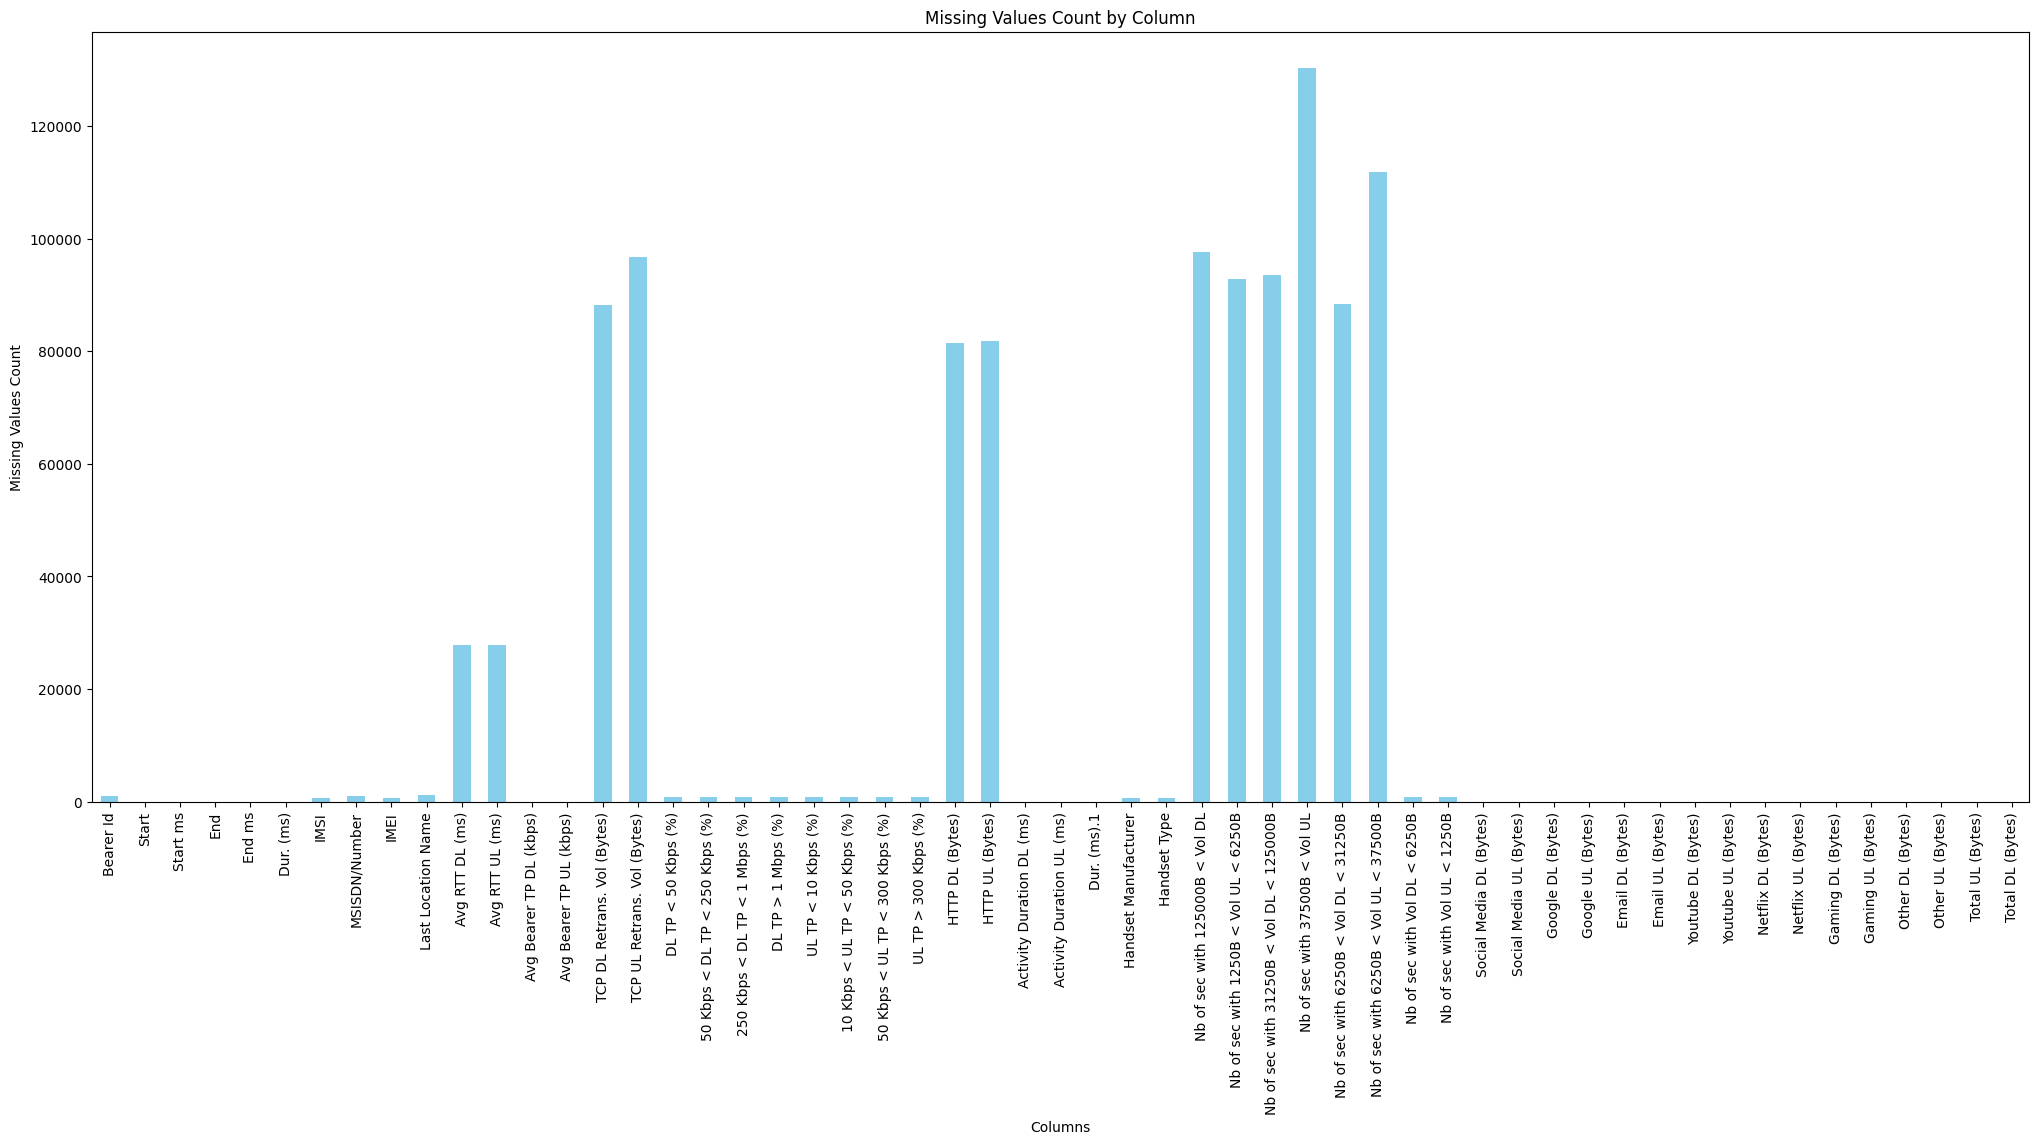

In [ ]:
# Count missing values in each column
missing_values_count = df.isnull().sum()

# Visualize missing values using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the missing values count using a bar plot
plt.figure(figsize=(25, 10))
missing_values_count.plot(kind='bar', color='skyblue')
plt.title('Missing Values Count by Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values Count')
plt.xticks(rotation=90)
plt.show()

Cleaninig Data

In [ ]:
import numpy as np

# Calculate the percentage of missing values for each column
#missing_percentages = (df.isna().mean() * 100).round(2)

# Display the result
#print("Percentage of missing values in each column:")
#print(missing_percentages)


# Calculate total number of cells in dataframe
totalCells = np.product(df.shape)

# Count number of missing values per column
missingCount = df.isnull().sum()

# Calculate total number of missing values
totalMissing = missingCount.sum()

print("The total cells contains",totalCells)
print("The missing  count is",totalMissing)

# Calculate percentage of missing values
print("The dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

# Impute missing values with a specific value, such as 0
df.fillna(0, inplace=True)

#drop row duplicates if any
df.drop_duplicates(inplace=True)


The total cells contains 8250055
The missing  count is 0
The dataset contains 0.0 % missing values.


In [ ]:
# top_10_handsets
top_10_handsets = df['Handset Type'].value_counts().head(10)
print("Top 10 Handsets:")
print(top_10_handsets)


Top 10 Handsets:
Handset Type
Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
undefined                        8987
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Name: count, dtype: int64


In [ ]:
# top_3_handset manfacturers
top_3_handset_manfacturers = df['Handset Manufacturer'].value_counts().head(3)
print("Top 3 Handset Manufacturers:")
print(top_3_handset_manfacturers)

Top 3 Handset Manufacturers:
Handset Manufacturer
Apple      59565
Samsung    40839
Huawei     34423
Name: count, dtype: int64


In [ ]:
# Aggregate usage of each handset type, grouped by manufacturer and type
usage_by_manufacturer_type = df.groupby(['Handset Manufacturer', 'Handset Type']).size().reset_index(name='usage_count')

# Identify the top 3 handset manufacturers based on usage
top_3_manufacturers = usage_by_manufacturer_type.groupby('Handset Manufacturer')['usage_count'].sum().nlargest(3).index

# Create an empty DataFrame to store the top 5 handset types per top 3 manufacturers
top_5_per_manufacturer = pd.DataFrame(columns=['Handset Manufacturer', 'Handset Type', 'usage_count'])

# Iterate over the top 3 manufacturers
for manufacturer in top_3_manufacturers:
    # Filter usage data for the current manufacturer
    manufacturer_data = usage_by_manufacturer_type[usage_by_manufacturer_type['Handset Manufacturer'] == manufacturer]
    
    # Get the top 5 handset types used by the current manufacturer
    top_5_handset_types = manufacturer_data.nlargest(5, 'usage_count')
    
    # Concatenate the top 5 handset types to the DataFrame
    top_5_per_manufacturer = pd.concat([top_5_per_manufacturer, top_5_handset_types])

# Reset index
top_5_per_manufacturer.reset_index(drop=True, inplace=True)

# Print the top 5 handset types per top 3 manufacturers
print("Top 5 Handset Types per Top 3 Manufacturers:")
print(top_5_per_manufacturer)


Top 5 Handset Types per Top 3 Manufacturers:
   Handset Manufacturer                    Handset Type usage_count
0                 Apple         Apple iPhone 6S (A1688)        9419
1                 Apple          Apple iPhone 6 (A1586)        9023
2                 Apple          Apple iPhone 7 (A1778)        6326
3                 Apple         Apple iPhone Se (A1723)        5187
4                 Apple          Apple iPhone 8 (A1905)        4993
5               Samsung    Samsung Galaxy S8 (Sm-G950F)        4520
6               Samsung      Samsung Galaxy A5 Sm-A520F        3724
7               Samsung     Samsung Galaxy J5 (Sm-J530)        3696
8               Samsung     Samsung Galaxy J3 (Sm-J330)        3484
9               Samsung    Samsung Galaxy S7 (Sm-G930X)        3199
10               Huawei                Huawei B528S-23A       19752
11               Huawei                    Huawei E5180        2079
12               Huawei  Huawei P20 Lite Huawei Nova 3E        2021
13 

In [ ]:
columns_to_sum = ['Social Media DL (Bytes)','Social Media UL (Bytes)', 'Google DL (Bytes)', 
  'Google UL (Bytes)', 'Email DL (Bytes)', 'Email UL (Bytes)', 'Youtube DL (Bytes)',
    'Youtube UL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)',
      'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)']

# Group the data by the user and sum the values of xDR sessions for each category
agg_data = df.groupby('MSISDN/Number')[columns_to_sum].sum()

# Sum the xDR sessions across all categories to get the total xDR sessions per user
agg_data['Total xDR sessions'] = agg_data.sum(axis=1)

# Print the aggregated data
print("Aggregated data per user:")
print(agg_data['Total xDR sessions'])


Aggregated data per user:
MSISDN/Number
0.000000e+00    9.736730e+11
3.360100e+10    1.255788e+09
3.360100e+10    4.364173e+08
3.360100e+10    1.091053e+09
3.360101e+10    4.475687e+08
                    ...     
3.379000e+10    1.006033e+09
3.379000e+10    6.849434e+08
3.197021e+12    6.998021e+08
3.370000e+14    7.406419e+08
8.823971e+14    5.283134e+08
Name: Total xDR sessions, Length: 106857, dtype: float64
